In [1]:
import tensorflow as tf
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import scipy
import os
from glob import glob
from tqdm import tqdm
import tensorflow_datasets as tfds
from IPython import display

In [2]:
# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Importing Data

[Dataset Paper](https://arxiv.org/pdf/1804.03209)

[Dataset importer github](https://github.com/tensorflow/datasets/tree/master/tensorflow_datasets/datasets/speech_commands)

[TF example for data subset](https://www.tensorflow.org/tutorials/audio/simple_audio)

Right now we will only be using a mini dataset to explore data and test data augmentations plus do some preliminary model training and quantization

In [3]:
# Define the dataset path, if it doesn't exist, download and extract it
DATASET_PATH = 'data/mini_speech_commands'
data_dir = pathlib.Path(DATASET_PATH)

# Download the dataset if it's not available locally
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

In [4]:
# List the available commands in the dataset, excluding any unnecessary files
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [5]:
# Load the dataset, ensuring no batch size is applied and output length is set to 1 second (16000 samples)
ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=None, #Unbatched dataset
    validation_split=0, #We will do split manually
    seed=seed,
    output_sequence_length=16000
    )

label_names = np.array(ds.class_names)
print()
print("label names:", label_names)

Found 8000 files belonging to 8 classes.

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [6]:
# Define which keywords are "target" (commands to recognize) and which are "unknown"
target_keywords = ['up', 'down', 'left', 'right']
unknown_keywords = [label for label in label_names if label not in target_keywords]

print("Target Keywords:", target_keywords)
print("Unknown Keywords:", unknown_keywords)

Target Keywords: ['up', 'down', 'left', 'right']
Unknown Keywords: ['go', 'no', 'stop', 'yes']


In [7]:
# Create a mapping of new label names, including "unknown" and "silence"
new_label_names = ['up', 'down', 'left', 'right', 'unknown', 'silence']
new_class_to_index = {name: index for index, name in enumerate(new_label_names)}
print("New Class to Index Mapping:", new_class_to_index)

# Map old label indices to new label indices (e.g., "unknown" and "silence")
old_label_to_new_label_index = {}
for idx, label_name in enumerate(label_names):
    if label_name in target_keywords:
        new_label = label_name
    else:
        new_label = 'unknown'
    new_label_index = new_class_to_index[new_label]
    old_label_to_new_label_index[idx] = new_label_index

# Convert the old label mapping to a constant tensor for fast lookup
mapping_array = tf.constant([old_label_to_new_label_index[idx] for idx in range(len(label_names))], dtype=tf.int32)


New Class to Index Mapping: {'up': 0, 'down': 1, 'left': 2, 'right': 3, 'unknown': 4, 'silence': 5}


In [8]:
# Function to map old labels to new labels in the dataset
def map_labels(sample, label):
    # Map the old label index to the new label index
    new_label = tf.gather(mapping_array, label)
    return sample, new_label

# Map labels in the dataset
ds = ds.map(map_labels)

In [9]:
# Number of silence samples to add
num_silence_samples = 1000  # Adjust as needed

# Function to generate 1-second silence samples (all zeros)
def generate_silence_sample():
    # Create a 1-second silent audio sample at 16kHz
    sample = tf.zeros([16000], dtype=tf.float32)
    # Assign the label index for 'silence'
    label = new_class_to_index['silence']
    return sample, label

# Create a dataset of silence samples
silence_ds = tf.data.Dataset.from_tensor_slices([0]*num_silence_samples)
silence_ds = silence_ds.map(lambda x: generate_silence_sample())

In [10]:
# Combine the original dataset with the silence dataset
ds = ds.concatenate(silence_ds)

In [11]:
# Getting the size of the dataset (number of samples)
dataset_size = len(list(ds))

# Iterating over the dataset to get the shape of each sample
for audio, label in ds.take(1):  # Take a single sample for inspection
    audio_shape = audio.shape
    print(f"Audio shape: {audio_shape}")
    print(f"Label shape: {label.shape}")

# Print dataset size
print(f"Dataset size: {dataset_size}")

Audio shape: (16000, 1)
Label shape: ()
Dataset size: 9000


In [12]:
def augment_audio_data(audio, sr):
    """Apply multiple audio augmentations to a single audio sample."""
    # Ensure audio is exactly 1 second long
    target_length = sr  # 1 second = sample rate
    if len(audio) < target_length:
        padding = target_length - len(audio)
        audio = np.pad(audio, (0, padding), mode='constant')
    else:
        audio = audio[:target_length]
    
    # Apply random augmentations in combination
    augmentations = ['time_stretch', 'pitch_shift', 'add_noise', 'volume_adjustment']

    selected_augmentations = np.random.choice(
        augmentations, 
        size=np.random.randint(1, len(augmentations) + 1), 
        replace=False
    )
    
    augmented_audio = audio.copy()
    
    # Time stretching
    if 'time_stretch' in selected_augmentations:
        time_stretch_factor = np.random.uniform(0.8, 1.2)
        augmented_audio = librosa.effects.time_stretch(y=augmented_audio, rate=time_stretch_factor)
        if len(augmented_audio) < target_length:
            padding = target_length - len(augmented_audio)
            augmented_audio = np.pad(augmented_audio, (0, padding), mode='constant')
        else:
            augmented_audio = augmented_audio[:target_length]
    
    # Pitch shifting
    if 'pitch_shift' in selected_augmentations:
        pitch_shift_steps = np.random.randint(-2, 2)  # -2 to +2 steps
        augmented_audio = librosa.effects.pitch_shift(
            y=augmented_audio, 
            sr=sr, 
            n_steps=pitch_shift_steps
        )
    
    # Adding white noise
    if 'add_noise' in selected_augmentations:
        noise = np.random.randn(len(augmented_audio))
        noise_factor = np.random.uniform(0.001, 0.01)
        augmented_audio = augmented_audio + noise_factor * noise
    
    # Volume adjustment
    if 'volume_adjustment' in selected_augmentations:
        volume_factor = np.random.uniform(0.5, 1.5)
        augmented_audio = augmented_audio * volume_factor
    
    # Ensure float32 type and proper normalization
    augmented_audio = augmented_audio.astype(np.float32)
    
    return augmented_audio

In [13]:
import numpy as np
import librosa

def apply_time_stretch(audio):
    """
    Apply time-stretching augmentation to the audio array.
    This function avoids the issue with extra arguments being passed.
    """
    try:

        time_stretch_factor = np.random.uniform(0.8, 1.2)
        augmented_audio = librosa.effects.time_stretch(y=audio, rate=time_stretch_factor)
        if len(augmented_audio) < 16000:
            padding = 16000 - len(augmented_audio)
            augmented_audio = np.pad(augmented_audio, (0, padding), mode='constant')
        else:
            augmented_audio = augmented_audio[:16000]

        return augmented_audio
        # Stretching factor between 0.8 (slower) and 1.2 (faster)
        # return librosa.effects.time_stretch(audio, np.random.uniform(0.8, 1.2))
    except Exception as e:
        print(f"Error applying time stretch: {e}")
        return audio  # If there is an error, return the original audio unchanged

def augment_audio_data(audio, sr=16000, max_augmentations=5, max_repeats_list=None):
    """
    Apply multiple audio augmentations to a single audio sample with limits on repetitions.
    
    Args:
        audio: The input audio sample as a numpy array.
        sr: The sample rate (default is 16000 for 1 second).
        max_augmentations: The total number of augmentations to apply.
        max_repeats_list: List of maximum number of times each augmentation can be applied.
                          The order corresponds to ['time_stretch', 'pitch_shift', 'add_noise', 'volume_adjustment'].
    
    Returns:
        Augmented audio array.
    """
    # Ensure the audio is exactly 1 second long (padded or trimmed)
    audio = np.pad(audio, (0, max(0, sr - len(audio))), mode='constant')[:sr]
    
    # Define augmentation functions with ranges for their parameters
    augmentations = {
        'time_stretch': apply_time_stretch,  # Call the separated function for time stretch
        'pitch_shift': lambda a: librosa.effects.pitch_shift(a, sr=sr, n_steps=np.random.uniform(-2, 2)),
        'add_noise': lambda a: a + np.random.normal(0, np.random.uniform(0.001, 0.01), a.shape),
        'volume_adjustment': lambda a: a * np.random.uniform(0.5, 1.5)
    }
    
    # Set repeat limits from the provided list
    if max_repeats_list is None:
        max_repeats_list = [float('inf')] * len(augmentations)
    max_repeats = dict(zip(augmentations.keys(), max_repeats_list))
    
    # Initialize a counter to track how many times each augmentation has been applied
    augmentation_count = {key: 0 for key in augmentations}
    
    # Randomly select a number of augmentations to apply (with consideration for limits)
    selected_augmentations = []
    
    for _ in range(max_augmentations):
        # Filter augmentations that have not exceeded their limit
        available_augmentations = [aug for aug in augmentations if augmentation_count[aug] < max_repeats[aug]]
        
        # If no augmentations are available to apply, break early
        if not available_augmentations:
            break
        
        # Randomly choose one augmentation from the available augmentations
        selected_aug = np.random.choice(available_augmentations)
        selected_augmentations.append(selected_aug)
        
        # Increment the count for the selected augmentation
        augmentation_count[selected_aug] += 1
    
    # Apply the selected augmentations
    augmented_audio = audio.copy()
    for aug in selected_augmentations:
        try:
            augmented_audio = augmentations[aug](augmented_audio)
        except Exception as e:
            print(f"Error applying {aug}: {e}")
    
    # Ensure float32 type for compatibility
    return augmented_audio.astype(np.float32)


In [14]:
@tf.function
def augment_sample(audio, label):
    """
    TensorFlow wrapper for audio augmentation.
    
    Args:
        audio: tensor of shape (16000, 1)
        label: tensor of shape ()
    
    Returns:
        Tuple of (augmented_audio, label)
    """
    # Reshape audio to (16000,) from (16000, 1) for augmentation
    audio_flat = tf.reshape(audio, [16000])

    # Apply augmentation using numpy_function
    augmented_audio = tf.numpy_function(
        func=augment_audio_data,
        inp=[audio_flat, tf.constant(16000, dtype=tf.int32)],
        Tout=tf.float32
    )
    
    # Forcefully reshape back to (16000, 1) to ensure consistency
    augmented_audio = tf.reshape(augmented_audio, [16000, 1])

    return augmented_audio, label

In [15]:
@tf.function
def augment_sample(audio, label, max_augmentations=5, max_repeats=None):
    """
    TensorFlow wrapper for audio augmentation using numpy_function.
    
    Args:
        audio: tensor of shape (16000, 1).
        label: tensor of shape ().
        max_augmentations: Maximum number of augmentations to apply to the audio.
        max_repeats: List of max times each augmentation can be applied, or defaults.
    
    Returns:
        Tuple of (augmented_audio, label).
    """
    # Reshape audio to (16000,) from (16000, 1) for augmentation
    audio_flat = tf.reshape(audio, [16000])

    # If no max_repeats is provided, use default values for all augmentations
    if max_repeats is None:
        max_repeats = [1, 2, 3, 2]  # Default repeat limits for ['time_stretch', 'pitch_shift', 'add_noise', 'volume_adjustment']

    # Apply augmentation using numpy_function
    augmented_audio = tf.numpy_function(
        func=augment_audio_data,
        inp=[audio_flat, tf.constant(16000, dtype=tf.int32), max_augmentations, max_repeats],
        Tout=tf.float32
    )
    
    # Forcefully reshape back to (16000, 1) to ensure consistency
    augmented_audio = tf.reshape(augmented_audio, [16000, 1])

    return augmented_audio, label


In [16]:
def create_augmented_dataset(original_ds, num_samples=2000, seed=42):
    """
    Create an augmented dataset and combine it with the original dataset.
    
    Args:
        original_ds: Original TensorFlow dataset
        num_samples: number of samples to augment
        seed: random seed for reproducibility
    
    Returns:
        Combined dataset (original + augmented)
    """
    # Filter out silence samples and take random samples
    non_silence_ds = original_ds.filter(
        lambda audio, label: label != new_class_to_index['silence']
    )
    
    selected_samples = non_silence_ds.shuffle(
        buffer_size=9000, 
        seed=seed
    ).take(num_samples)
    
    # Apply augmentation with parallel processing and ensure consistent shapes
    augmented_ds = selected_samples.map(
        augment_sample,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Make sure both the original and augmented datasets are reshaped properly
    augmented_ds = augmented_ds.map(
        lambda audio, label: (tf.reshape(audio, [16000, 1]), label),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    
    return augmented_ds

In [17]:
def create_augmented_dataset(original_ds, num_samples=2000, seed=42, max_augmentations=5, max_repeats=None):
    """
    Create an augmented dataset and combine it with the original dataset.
    
    Args:
        original_ds: Original TensorFlow dataset.
        num_samples: Number of samples to augment.
        seed: Random seed for reproducibility.
        max_augmentations: Maximum number of augmentations to apply to each audio sample.
        max_repeats: Dict of maximum times each augmentation can be applied.
    
    Returns:
        Combined dataset (original + augmented).
    """
    # Filter out silence samples and take random samples
    non_silence_ds = original_ds.filter(
        lambda audio, label: label != new_class_to_index['silence']
    )
    
    selected_samples = non_silence_ds.shuffle(
        buffer_size=9000, 
        seed=seed
    ).take(num_samples)
    
    # Apply augmentation with parallel processing and ensure consistent shapes
    augmented_ds = selected_samples.map(
        lambda audio, label: augment_sample(audio, label, max_augmentations, max_repeats),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Make sure both the original and augmented datasets are reshaped properly
    augmented_ds = augmented_ds.map(
        lambda audio, label: (tf.reshape(audio, [16000, 1]), label),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    return augmented_ds


In [18]:
max_repeats = [1, 2, 3, 2] 
# Max times for ['time_stretch', 'pitch_shift', 'add_noise', 'volume_adjustment']

# Get original dataset size
original_size = len(list(ds))
print(f"Original dataset size: {original_size}")

# Create combined dataset with augmentations
augmented_ds = create_augmented_dataset(ds, num_samples=8000, seed=42)

combined_ds = ds.concatenate(augmented_ds)

# Verify the new dataset size
new_size = len(list(combined_ds))
print(f"New dataset size: {new_size}")

# Verify data shapes
for audio, label in combined_ds.take(1):
    print(f"Audio shape: {audio.shape}")
    print(f"Label shape: {label.shape}")

Original dataset size: 9000
New dataset size: 17000
Audio shape: (16000, 1)
Label shape: ()


In [19]:
# Function to check if all elements in a dataset have the same shape
def check_dataset_shape_consistency(ds):
    # Initialize a variable to store the first shape
    first_shape = None
    consistent = True
    
    for audio, label in ds:
        # Get the current audio shape
        current_shape = audio.shape
        
        if first_shape is None:
            # Store the first shape as a reference
            first_shape = current_shape
        else:
            # Check if the current shape matches the first shape
            if current_shape != first_shape:
                consistent = False
                print(f"Inconsistent shape found: {current_shape}")
                break
    
    if consistent:
        print(f"All elements have the same shape: {first_shape}")
    else:
        print("Dataset contains elements with inconsistent shapes.")


In [20]:
# Example usage (assuming `ds` is your dataset)
check_dataset_shape_consistency(combined_ds)

Inconsistent shape found: (16000,)
Dataset contains elements with inconsistent shapes.


In [21]:
# Reverse mapping from indices to class names
index_to_class = {index: name for name, index in new_class_to_index.items()}


In [22]:
for i in range(6):
    print(index_to_class[i])

up
down
left
right
unknown
silence


In [23]:
def squeeze_audio_shape(audio, label):
        # Squeeze audio from (16000, 1) to (16000)
        audio = tf.reshape(audio, [16000, 1])
        audio_squeezed = tf.squeeze(audio, axis=-1)
        return audio_squeezed, label

# Apply the squeeze function to the entire dataset
ds_squeezed = combined_ds.map(squeeze_audio_shape, num_parallel_calls=tf.data.AUTOTUNE)

In [24]:
# Verify the new dataset size
new_size = len(list(ds_squeezed))
print(f"New dataset size: {new_size}")

# Verify data shapes
for audio, label in ds_squeezed.take(1):
    print(f"Audio shape: {audio.shape}")
    print(f"Label shape: {label.shape}")

New dataset size: 17000
Audio shape: (16000,)
Label shape: ()


In [25]:
# Initialize a dictionary to store one sample per class
samples_per_class = {}

# Iterate through the unbatched dataset
for sample, label in ds_squeezed:
    label_int = label.numpy()
    label_name = index_to_class[label_int]
    # If we haven't collected a sample for this class yet, store it
    if label_name not in samples_per_class:
        samples_per_class[label_name] = sample.numpy()
    # Break the loop if we've collected samples for all classes
    if len(samples_per_class) == len(new_label_names):
        break

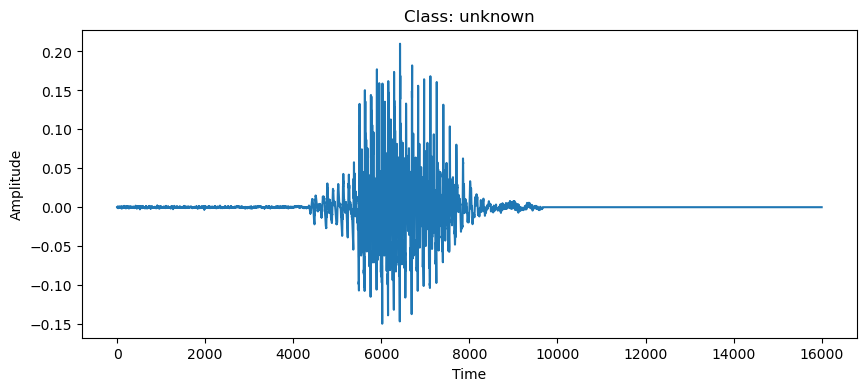

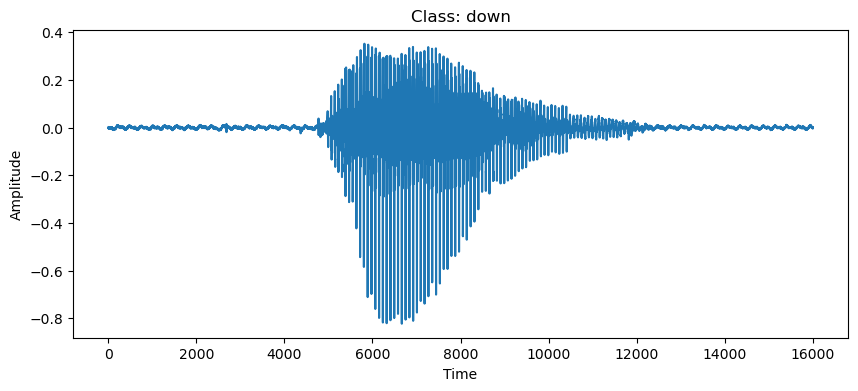

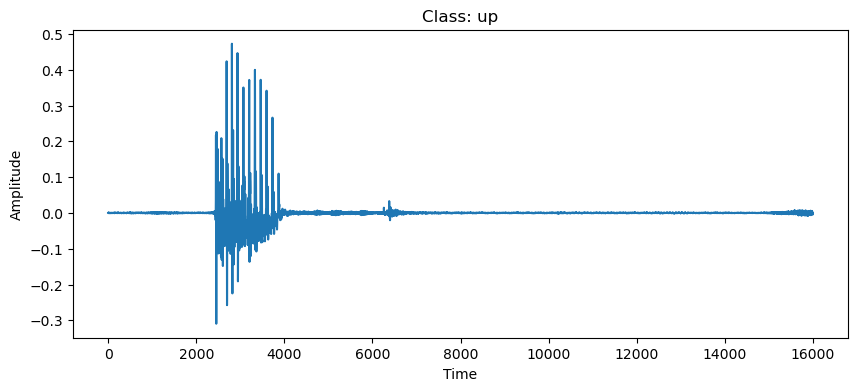

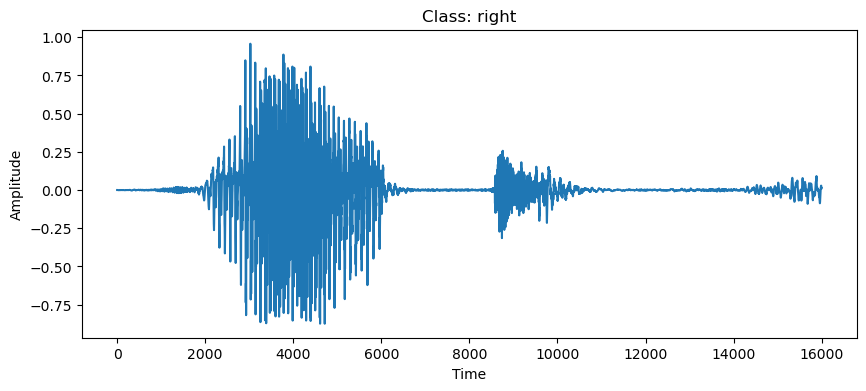

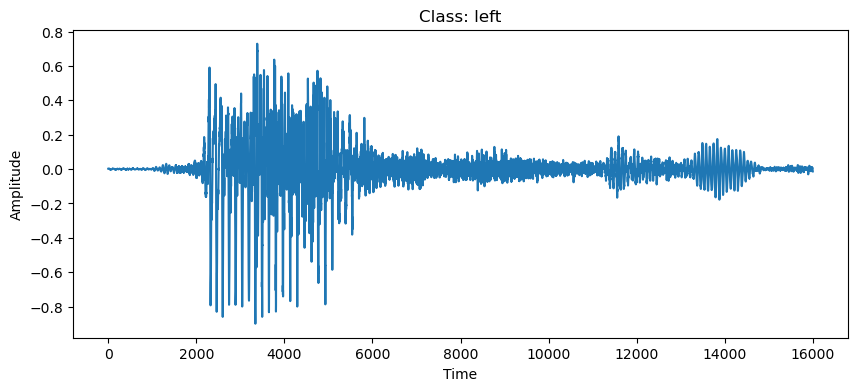

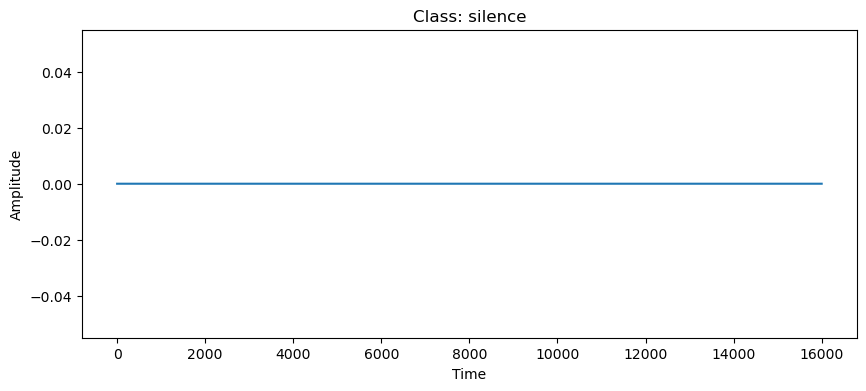

In [26]:
# Plotting the waveforms
for label_name, sample in samples_per_class.items():
    # Reshape the sample to [16000] from [16000, 1] for plotting
    #plotted_sample = sample.reshape(-1)
    
    plt.figure(figsize=(10, 4))
    plt.plot(sample)
    plt.title(f"Class: {label_name}")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()

In [27]:
# Reset the unbatched dataset and cache it
ds_unbatched = ds_squeezed.cache()

# Count the total number of samples in dataset
total_samples = ds_unbatched.reduce(np.int64(0), lambda x, _: x + 1).numpy()
print(f"Total number of samples: {total_samples}")

Total number of samples: 17000


## Data Split

In [28]:
# Shuffle the dataset with a buffer size equal to the total number of samples
ds_unbatched = ds_unbatched.shuffle(total_samples, reshuffle_each_iteration=False)

In [29]:
# Calculate sizes for each split
train_size = int(0.8 * total_samples)
val_size = int(0.1 * total_samples)
test_size = total_samples - train_size - val_size  # Ensure all samples are included


In [30]:
# Create the training dataset
train_ds = ds_unbatched.take(train_size)

# Create the validation dataset
val_ds = ds_unbatched.skip(train_size).take(val_size)

# Create the test dataset
test_ds = ds_unbatched.skip(train_size + val_size)


In [31]:
# Define the batch size
batch_size = 64

# Batch the datasets
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

In [32]:
# Verify the new dataset size
#new_size = len(list(train_ds))
#print(f"New dataset size: {new_size}")

# Verify data shapes
for audio, label in train_ds.take(1):
    print(f"Audio shape: {audio.shape}")
    print(f"Label shape: {label.shape}")

Audio shape: (64, 16000)
Label shape: (64,)


In [33]:
# Function to count batches in a dataset
def count_batches(dataset):
    return sum(1 for _ in dataset)

# Count batches in each dataset
num_train_batches = count_batches(train_ds)
num_val_batches = count_batches(val_ds)
num_test_batches = count_batches(test_ds)

print(f"Number of training batches: {num_train_batches}")
print(f"Number of validation batches: {num_val_batches}")
print(f"Number of test batches: {num_test_batches}")

# Function to count samples in a dataset
def count_samples(dataset):
    return dataset.reduce(np.int32(0), lambda x, batch: x + tf.shape(batch[0])[0]).numpy()

# Count samples in each dataset
num_train_samples = count_samples(train_ds)
num_val_samples = count_samples(val_ds)
num_test_samples = count_samples(test_ds)

print(f"Number of training samples: {num_train_samples}")
print(f"Number of validation samples: {num_val_samples}")
print(f"Number of test samples: {num_test_samples}")

Number of training batches: 213
Number of validation batches: 27
Number of test batches: 27
Number of training samples: 13600
Number of validation samples: 1700
Number of test samples: 1700


## Convert to Spectogram

In [34]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [35]:
# Get one batch from the training dataset
for waveform_batch, label_batch in train_ds.take(1):
    example_waveforms = waveform_batch
    example_labels = label_batch

In [36]:
example_labels

<tf.Tensor: shape=(64,), dtype=int32, numpy=
array([4, 1, 4, 2, 4, 4, 1, 4, 4, 0, 4, 4, 4, 1, 4, 4, 4, 3, 1, 2, 1, 1,
       4, 4, 0, 4, 2, 0, 4, 2, 3, 4, 2, 0, 4, 3, 2, 2, 4, 4, 4, 0, 4, 4,
       2, 4, 0, 0, 3, 0, 0, 4, 4, 0, 3, 4, 4, 4, 4, 0, 1, 4, 0, 4])>

In [37]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

In [38]:
example_labels.numpy()

array([4, 1, 4, 2, 4, 4, 1, 4, 4, 0, 4, 4, 4, 1, 4, 4, 4, 3, 1, 2, 1, 1,
       4, 4, 0, 4, 2, 0, 4, 2, 3, 4, 2, 0, 4, 3, 2, 2, 4, 4, 4, 0, 4, 4,
       2, 4, 0, 0, 3, 0, 0, 4, 4, 0, 3, 4, 4, 4, 4, 0, 1, 4, 0, 4])

In [39]:
def first_seen(arr):
    pos = [0]
    seen = [arr[0]]
    for i, item in enumerate(arr):
        if item not in seen:
            pos.append(i)
            seen.append(item)
    return pos, seen

positions, seen = first_seen(example_labels.numpy())
print(positions)
print(seen)

[0, 1, 3, 9, 17]
[4, 1, 2, 0, 3]


Label: unknown
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


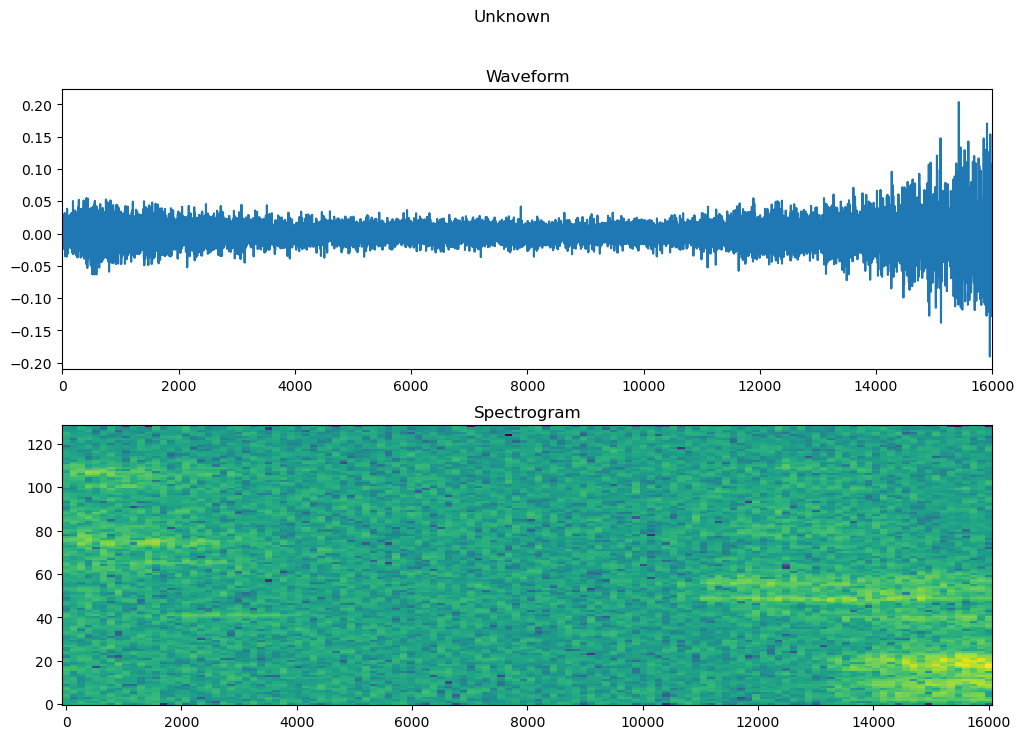

Label: down
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


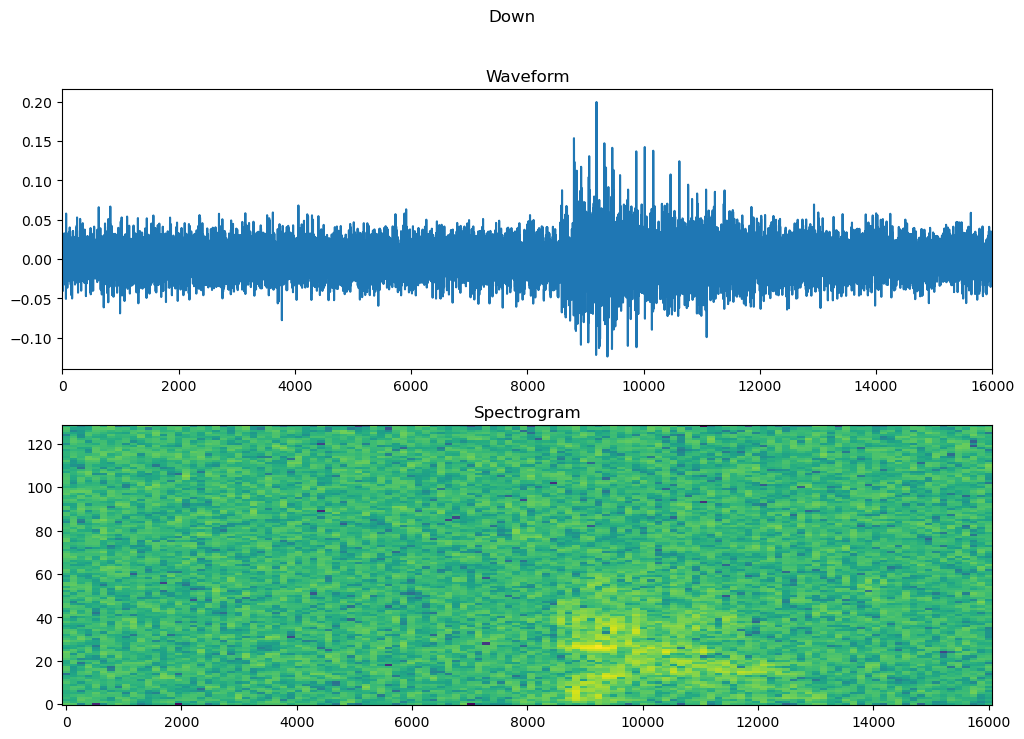

Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


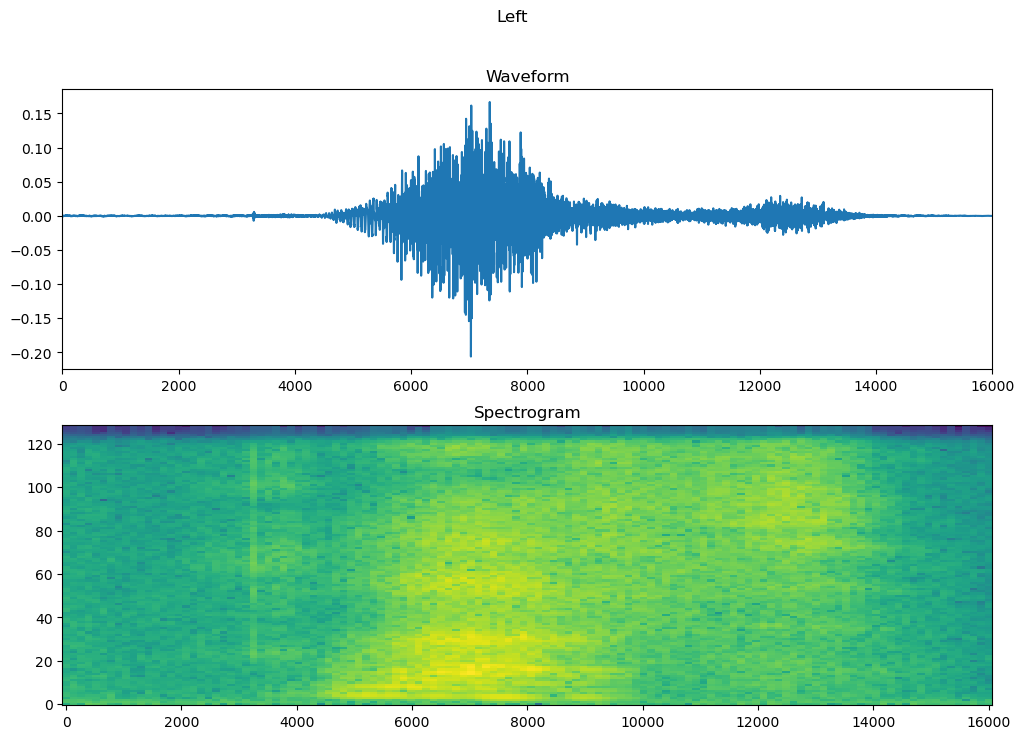

Label: up
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


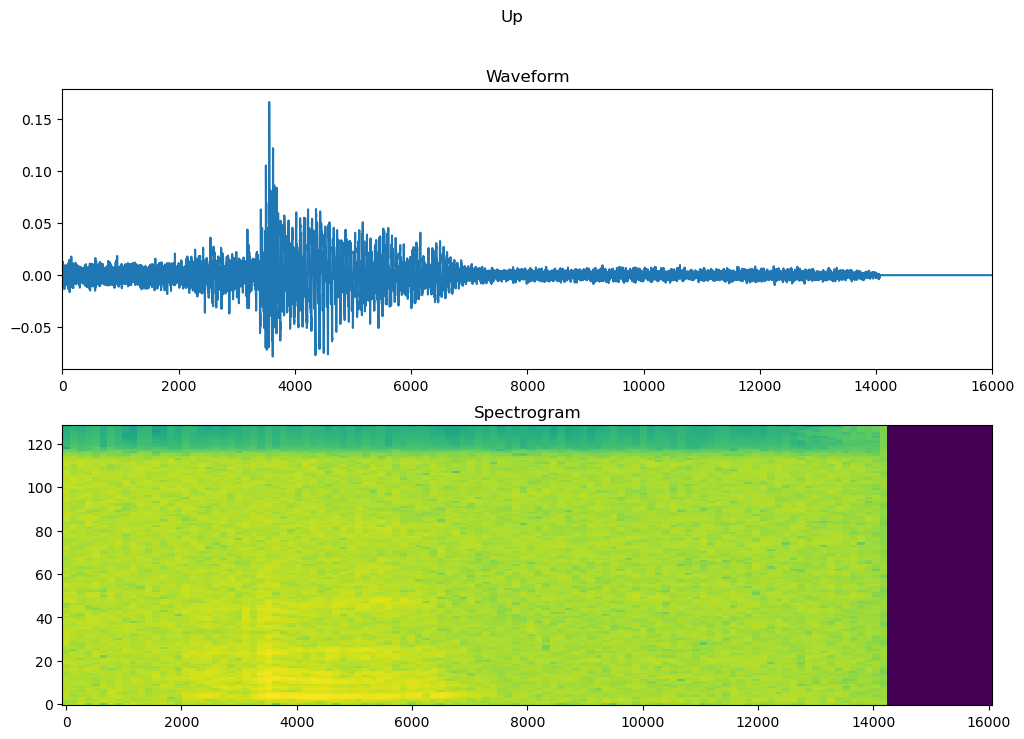

Label: right
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


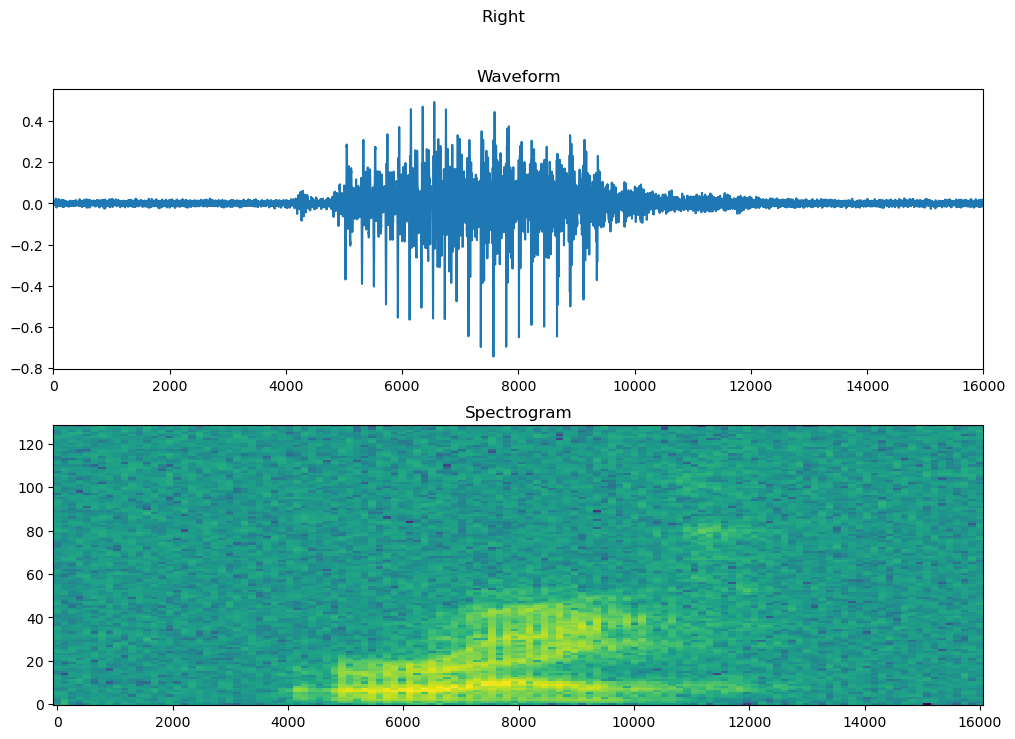

In [40]:
for i in positions:
  label = index_to_class[example_labels[i].numpy()]
  waveform = example_waveforms[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

  fig, axes = plt.subplots(2, figsize=(12, 8))
  timescale = np.arange(waveform.shape[0])
  axes[0].plot(timescale, waveform.numpy())
  axes[0].set_title('Waveform')
  axes[0].set_xlim([0, 16000])

  plot_spectrogram(spectrogram.numpy(), axes[1])
  axes[1].set_title('Spectrogram')
  plt.suptitle(label.title())
  plt.show()

In [41]:
# Function to convert dataset waveforms to spectrograms
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio, label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [42]:
# Apply the spectrogram conversion to the datasets
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

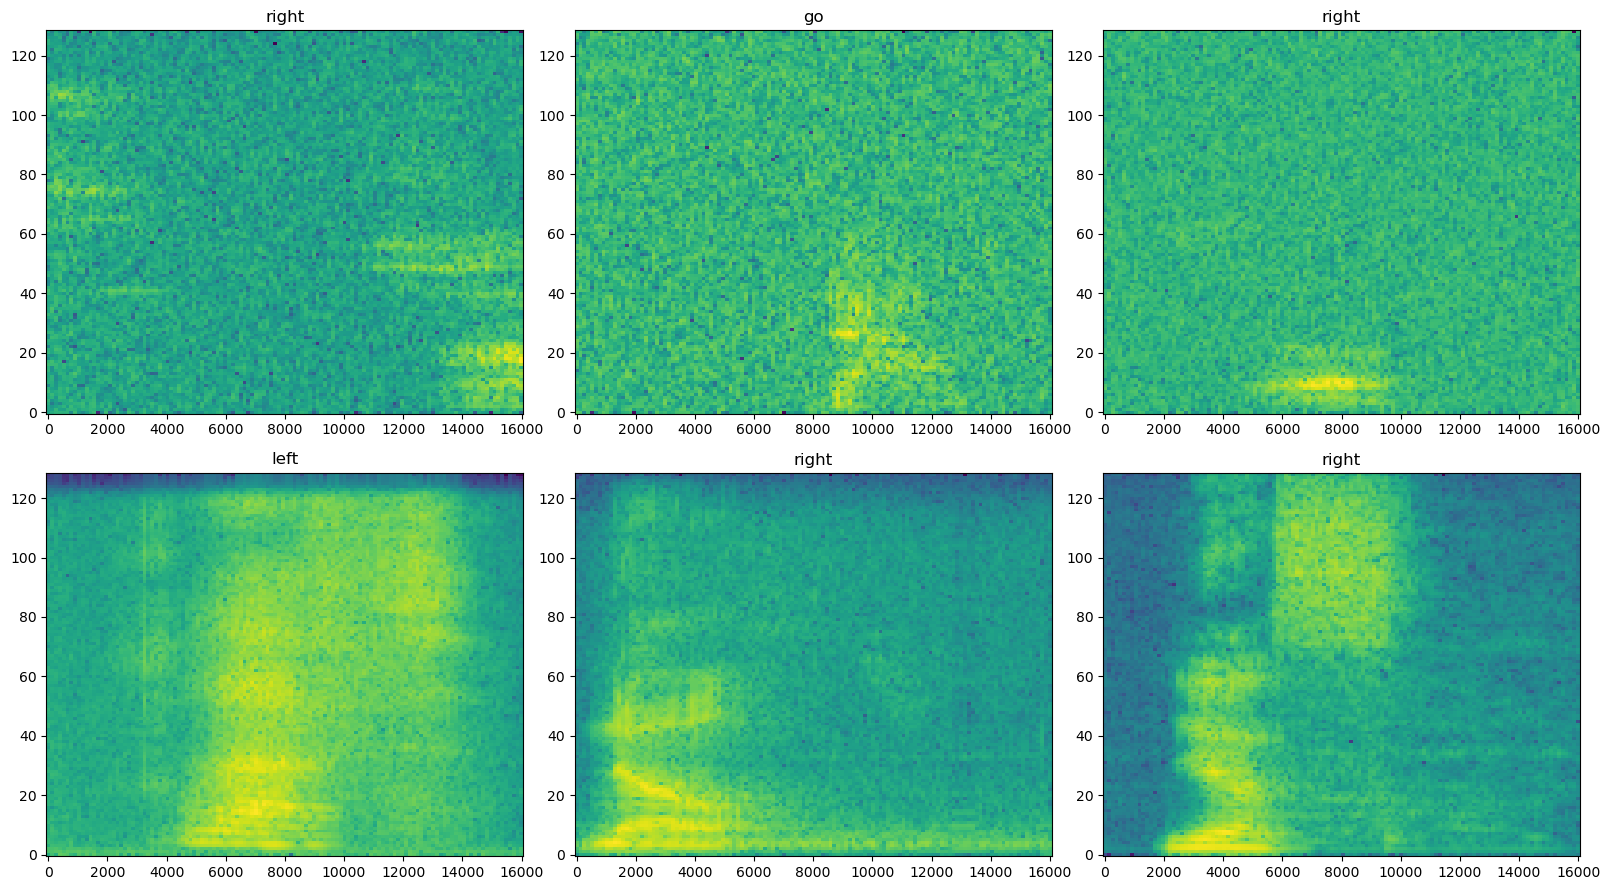

In [43]:
# Get one batch from the spectrogram dataset for visualization
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

rows = 2
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])
    
plt.tight_layout()
plt.show()


In [44]:
train_spectrogram_ds

<_ParallelMapDataset element_spec=(TensorSpec(shape=(None, 124, 129, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [50]:
# Path where the TFRecord file will be saved
train_spec_ds = 'train_spec_ds.tfrecord'
test_spec_ds = 'test_spec_ds.tfrecord'
val_spec_ds = 'val_spec_ds.tfrecord'


In [51]:
def _serialize_example(image, label):
    """
    Serialize a dataset element (image, label) into a TFRecord-compatible format.
    Handles batched data by iterating through each image in the batch.
    """
    serialized_examples = []
    
    # Loop through each image in the batch
    for i in range(image.shape[0]):  # Assuming first dimension is the batch size
        # Extract the single image from the batch
        single_image = image[i]  # Extract the single image
        
        # Rescale and convert the image to uint8 for JPEG encoding
        single_image_uint8 = tf.cast(tf.clip_by_value(single_image * 255.0, 0, 255), tf.uint8)
        
        # Ensure the image has 1 channel (do not squeeze completely)
        if single_image_uint8.shape[-1] != 1:
            single_image_uint8 = tf.expand_dims(single_image_uint8, axis=-1)  # Ensure single channel

        # Encode the image as JPEG (now it will have shape [124, 129, 1])
        single_image_encoded = tf.io.encode_jpeg(single_image_uint8).numpy()

        # Create a dictionary with features that map the image and label
        feature = {
            'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[single_image_encoded])),
            'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label[i].numpy()]))
        }

        # Create a Features message using tf.train.Example
        example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
        serialized_examples.append(example_proto.SerializeToString())
    
    return serialized_examples


In [52]:
def write_to_tfrecord(dataset, tfrecord_file):
    """
    Writes a batched dataset to a TFRecord file.
    """
    with tf.io.TFRecordWriter(tfrecord_file) as writer:
        for image, label in dataset:
            # Serialize all images in the batch
            serialized_examples = _serialize_example(image, label)
            
            # Write each serialized example to the TFRecord
            for serialized_example in serialized_examples:
                writer.write(serialized_example)


In [53]:
# Example: Write the dataset to TFRecord
write_to_tfrecord(train_spectrogram_ds, train_spec_ds)
write_to_tfrecord(test_spectrogram_ds, test_spec_ds)
write_to_tfrecord(val_spectrogram_ds, val_spec_ds)


In [54]:
new_size = len(list(train_spectrogram_ds))
print(f"New dataset size: {new_size}")

New dataset size: 213
